In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os

print(os.getpid())
%cd ../../

18605
/media/work/docs/codes/QuCF/scripts-py


In [2]:
import pylib.measurement as mse
import pylib.mix as mix
import pylib.EM_1D_sim as sim
import pylib.qucf_read as qucf_r

path_qucf_ = "../QuCF/simulations/MI/EM/"
name_qucf_pr_   = "MI"
name_qucf_file_ = name_qucf_pr_ + "_OUTPUT.hdf5"

path_save_plots_ = "./tools/QSVT-angles/inversion/saved-plots/"
for i in range(100):
    plt.close()

Modeling: Nx = 256

i*w + ih: 1.771e+01+1.000e+00j
i2h: 8.854e+00

--- Solve the system by the Gaussian method ---
time for inv. calc.: 2.227e-01 s


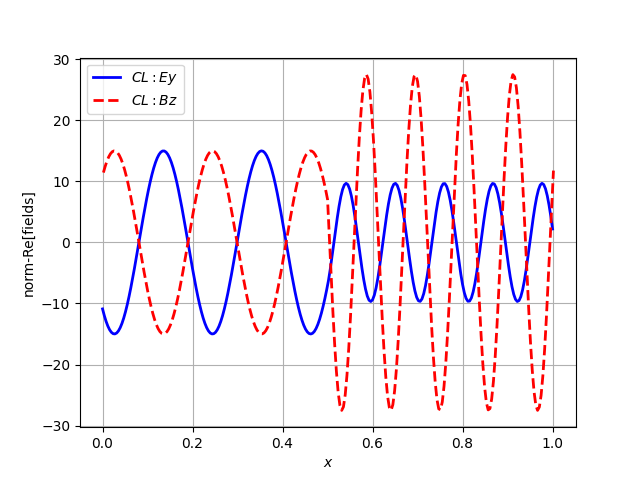

In [3]:
# ---------------------------------------------------------------------
# --- CLASSICAL: solve ---
# ---------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(sim)
def plotting_CL():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        vv_cl["xe"], np.real(Ey_cl), 
        color='b',  
        linewidth = 2, linestyle='-', 
        label = "$CL: Ey$"
    )
    ax.plot(
        vv_cl["xb"], np.real(Bz_cl), 
        color='r',  
        linewidth = 2, linestyle='--', 
        label = "$CL: Bz$"
    )
    plt.xlabel('$x$')
    plt.ylabel("norm-Re[fields]")
    ax.legend()
    plt.grid(True)
    plt.show()
    return
# -----------------------------------------------------------
nx_ = 8

# --- Formulate 1D EM system ---
dd_work = sim.init(nqx = nx_, nq_layers = 1, epss = [1,4], r0 = 4, kx = 7.2)
A, b    = sim.form_matrix(dd_work, flag_norm = True)
Nx_ = dd_work["Nx"]

# --- classical simulation ---
psi   = sim.solve_system(A, b, 0)
vv_cl = sim.get_vars(psi, dd_work)
Ey_cl = vv_cl["Ey"]
Bz_cl = vv_cl["Bz"]
plotting_CL()

In [5]:
# ------------------------------------------------------
# --- Find the condition number ---
# ------------------------------------------------------
_, s, _ = np.linalg.svd(A)
kappa_ref_ = np.max(np.abs(s)) / np.min(np.abs(s[np.nonzero(s)]))
print("nx, Nx: {:d}, {:d}".format(dd_work["nqx"], dd_work["Nx"]))
print("condition number as |sing_max|/|sing_min|: \t{:0.1f}".format(kappa_ref_))
del s

nx, Nx: 7, 128
condition number as |sing_max|/|sing_min|: 	407.5


Reading the file ../QuCF/simulations/MI/EM//results//EM_n8_k4.0e3_OUTPUT.hdf5...
Name of the simulation is EM
Simulation has been performed  08-08-2024 18:11:05
success prob [recheck]: 1.443e-04

nx: 8
kappa_qsvt: 4.000e+03
max. relative err: 1.185e-05


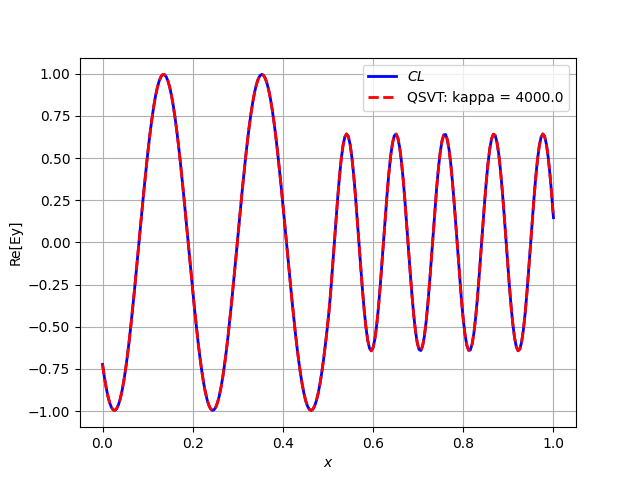

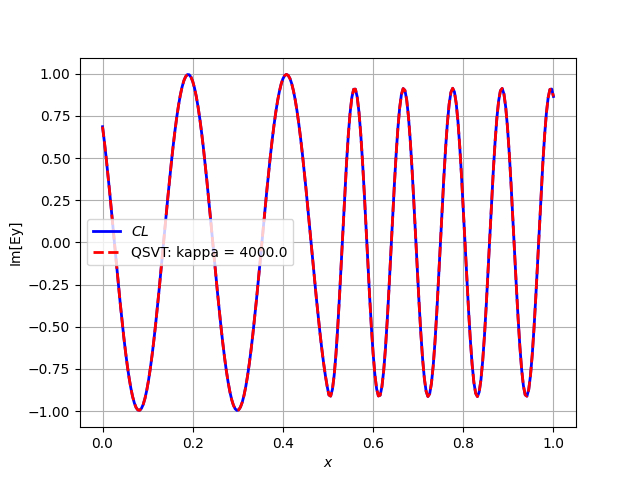

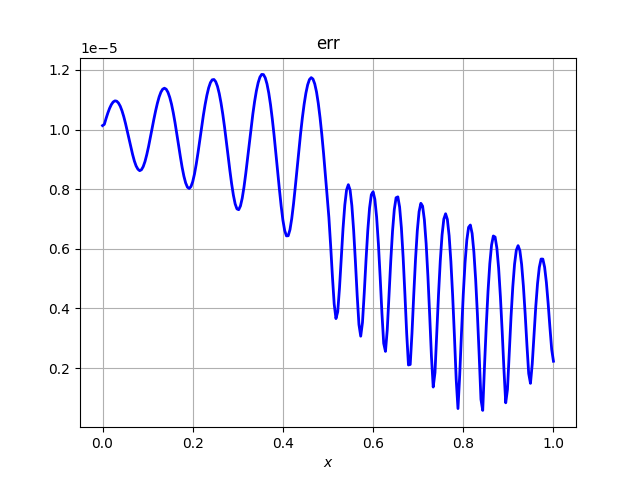

write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_ref_real.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_ref_imag.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_reco_real.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_reco_imag.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_error_x.dat


In [11]:
# ----------------------------------------------------------------------------------
# --- QC convergence: KAPPA ---
# ----------------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(mse)
def compare_with_qucf(kappa_qsvt, flag_save, flag_plot, flag_Ey):
    def read_qsvt_data(kappa_qsvt):
        km, ke = mix.get_order_base10(kappa_qsvt)
        str_k = "{:0.1f}e{:d}".format(km, ke)
        # pr_name = "MI_k{:s}".format(str_k)
        pr_name = "EM_n{:d}_k{:s}".format(dd_work["nqx"], str_k)

        # --- Reading the QuCF data ---
        oor_curr = mse.MeasOracle__()
        oor_curr.pname_ = pr_name
        oor_curr.path_  = path_qucf_ + "/results/"
        oor_curr.open()
        oor_curr.read_qsvt()
        oor_curr.set_zero_ancillae_work_states(id_input_state = 0)
        
        rescaling_factor = oor_curr.dd_["MI"]["rescaling_factor"]
        kappa_qc = oor_curr.dd_["MI"]["par"]
        if np.abs(kappa_qc - kappa_qsvt) > 1e-4:
            print()
            print("<<< ERROR: a wrong QSVT parameter.>>>")
            print()
        
        # --- x-grid ---
        x_e_qc_curr = oor_curr.get_x_grid("j")
        shift_x = (x_e_qc_curr[1] - x_e_qc_curr[0])/2.
        x_b_qc_curr = shift_x + x_e_qc_curr # coord.-axis for the magnetic field;

        # --- E, B fields ---
        Ey_qc_curr = oor_curr.get_var_x({"d": 0}, "j")
        Bz_qc_curr = oor_curr.get_var_x({"d": 1}, "j")
        
        prob = np.sum(np.abs(Ey_qc_curr)**2) + np.sum(np.abs(Bz_qc_curr)**2)
        print("success prob [recheck]: {:0.3e}".format(prob))
        
        # --- renormalize the fields ---
        coef_norm = kappa_qc / rescaling_factor
        Ey_qc_curr = coef_norm * Ey_qc_curr
        Bz_qc_curr = coef_norm * Bz_qc_curr
        return Ey_qc_curr, Bz_qc_curr, x_e_qc_curr
    # ------------------------------------------------------------------------------

    # --- Reading QuCF data ---
    Ey_qc, Bz_qc, x_e_qc = read_qsvt_data(kappa_qsvt)
    
    # --- Choose the signal ---
    if flag_Ey:
        y_reco = Ey_qc
        y_ref = np.array(Ey_cl)
    else:
        y_reco = Bz_qc
        y_ref = np.array(Bz_cl)

    # --- correct the global factor of QuCF data ---
    y_reco = 1j * y_reco
    if int(y_reco.imag[0]/np.abs(y_reco.imag[0])) != int(y_ref.imag[0]/np.abs(y_ref.imag[0])):
        y_reco.imag = - y_reco.imag
    else:
        y_reco.real = - y_reco.real

    # --- normalize the signals ---
    norm_coef  = np.max(np.abs(y_ref))
    y_ref  /= norm_coef
    y_reco /= norm_coef

    # --- Relative error ---
    norm_diff = np.abs(y_ref - y_reco)
    max_rel_err = np.max(np.abs(norm_diff))

    # --- Print some parameters and results ---
    print()
    print("nx: {:d}".format(dd_work["nqx"]))
    print("kappa_qsvt: {:0.3e}".format(kappa_qsvt))
    print("max. relative err: {:0.3e}".format(max_rel_err))

    # --- Plotting: comparison: Re ---
    if flag_plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(
            vv_cl["xe"], y_ref.real, 
            color='b', linewidth = 2, linestyle='-', 
            label = "$CL$"
        )
        ax.plot(
            x_e_qc, y_reco.real, 
            color="r", linewidth = 2, linestyle='--', 
            label = "QSVT: kappa = {:0.1f}".format(kappa_qsvt)
        )
        plt.xlabel('$x$')
        plt.ylabel("Re[Ey]")
        ax.legend()
        plt.grid(True)
        plt.show()

        # --- Plotting: comparison: Im ---
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(
            vv_cl["xe"], y_ref.imag, 
            color='b', linewidth = 2, linestyle='-', 
            label = "$CL$"
        )
        ax.plot(
            x_e_qc, y_reco.imag, 
            color="r", linewidth = 2, linestyle='--', 
            label = "QSVT: kappa = {:0.1f}".format(kappa_qsvt)
        )
        plt.xlabel('$x$')
        plt.ylabel("Im[Ey]")
        ax.legend()
        plt.grid(True)
        plt.show()

        # --- Plotting: relative error ---
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(vv_cl["xe"], norm_diff, color='b', linewidth = 2, linestyle='-')
        plt.xlabel('$x$')
        plt.title("err")
        plt.grid(True)
        plt.show()


    if flag_save:
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_EM_ref_real.dat", 
            vv_cl["xe"], y_ref.real
        )
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_EM_ref_imag.dat", 
            vv_cl["xe"], y_ref.imag
        )
        
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_EM_reco_real.dat", 
            x_e_qc, y_reco.real
        )
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_EM_reco_imag.dat", 
            x_e_qc, y_reco.imag
        )

        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_EM_error_x.dat", 
            # vv_cl["xe"], np.log10(norm_diff)
            vv_cl["xe"], norm_diff
        )
    return
# ----------------------------------------------------------------------------------

# # --- for nx = 7 ---
# kappa_qsvt_ = 2500 #   500, 1000, 1500, 2000, 2500, 3000

# --- for nx = 8 ---
kappa_qsvt_ = 4000 #   800,  1500,  2000, 3000, 4000, 5000

# # --- for nx = 9 ---
# kappa_qsvt_ = 1e4 #   2e3, 4e3, 6e3, 8e3, 1e4

# # --- for nx = 10 ---
# kappa_qsvt_ = 3.0e4 #   0.5e4, 1.0e4, 1.5e4, 2.0e4, 2.5e4, 3.0e4

# # --- for nx = 11 ---
# kappa_qsvt_ = 6.0e4 #   1.1e4, 2.0e4, 3.0e4, 4.0e4, 5.0e4, 6.0e4

# # --- for nx = 12 ---
# kappa_qsvt_ = 2.8e4 #   2.8e4, 6.0e4, 9.0e4, 1.2e5, 1.5e5, 1.8e5

compare_with_qucf(
    kappa_qsvt = kappa_qsvt_,
    flag_plot = True,
    flag_save = True,
    flag_Ey = True
)

In [9]:
# ----------------------------------------------------------------
# --- Save scans ---
# ----------------------------------------------------------------
def save_scans():
    def scan_sp_norm():
        nx_array      = [        7,         8,         9,        10]
        sp_norm_array = [2.081e-01, 2.045e-01, 2.037e-01, 2.035e-01]
        # mix.save_dat_plot_1d_file(
        #     path_save_plots_ + "/QSVT_EM_BE_sp_norm_nx.dat", 
        #     nx_array, sp_norm_array
        # )
        return
    # -------------------------------------------------------------------------
    def scan_kappa():
        nx_array = [    7,     8,      9,     10,      11,      12]
        k_array  = [407.5, 800.7, 1748.3, 4125.1, 10426.3, 27690.6]
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_EM_kappa_nx.dat", 
            nx_array, k_array
        )
        return
    # -------------------------------------------------------------------------
    def scan_err_n7():
        nx = 7
        k_array = \
            [      500,      1000,     1500,       2000,      2500]
        err_array    = \
            [2.026e-01, 1.554e-03, 1.428e-05, 9.723e-06, 6.708e-06]
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_EM_err_nx{:d}.dat".format(nx), 
            # k_array, np.log10(err_array)
            k_array, err_array
        )
        return
    # -------------------------------------------------------------------------
    def scan_err_n8():
        nx = 8
        k_array = \
            [      800,      1500,      2000,      3000,      4000,      5000]
        err_array    = \
            [3.557e-01, 2.571e-02, 1.514e-03, 1.986e-05, 1.185e-05, 7.786e-06]
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_EM_err_nx{:d}.dat".format(nx), 
            # k_array, np.log10(err_array)
            k_array, err_array
        )
        return
    # -------------------------------------------------------------------------
    def scan_err_n9():
        nx = 9
        k_array = \
            [      2e3,       4e3,       6e3,       8e3,       1e4]
        err_array    = \
            [2.380e-01, 4.048e-03, 2.964e-05, 1.459e-05, 9.335e-06]
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_EM_err_nx{:d}.dat".format(nx),  
            # k_array, np.log10(err_array)
            k_array, err_array
        )
        return
    # -------------------------------------------------------------------------
    def scan_err_n10():
        nx = 10
        k_array = \
            [    0.5e4,     1.0e4,     1.5e4,     2.0e4,     2.5e4,     3.0e4]
        err_array    = \
            [1.747e-01, 1.844e-03, 2.282e-05, 1.221e-05, 8.140e-06, 5.420e-06]
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_EM_err_nx{:d}.dat".format(nx), 
            # k_array, np.log10(err_array)
            k_array, err_array
        )
        return
    # -------------------------------------------------------------------------
    def scan_err_n11():
        nx = 11
        k_array = \
            [    1.1e4,     2.0e4,     3.0e4,     4.0e4,     5.0e4,     6.0e4]
        err_array    = \
            [2.202e-01, 1.520e-02, 1.612e-04, 1.791e-05, 1.116e-05, 7.795e-06]
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_EM_err_nx{:d}.dat".format(nx),  
            # k_array, np.log10(err_array)
            k_array, err_array
        )
        return
    # -------------------------------------------------------------------------
    def scan_err_n12():
        nx = 12
        k_array = \
            [    2.8e4,     6.0e4,     9.0e4,     1.2e5,     1.5e5,     1.8e5]
        err_array    = \
            [2.161e-01, 4.814e-03, 3.365e-05, 1.265e-05, 8.241e-06, 5.393e-06]
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_EM_err_nx{:d}.dat".format(nx),  
            # k_array, np.log10(err_array)
            k_array, err_array
        )
        return

    # -------------------------------------------------------------------------
    # --- kappa versus nx ---
    scan_kappa()

    # --- Spectral norm ---
    scan_sp_norm()

    # --- Errors in Ey signal: eps vs kappa_qsvt ---
    scan_err_n7()
    scan_err_n8()
    scan_err_n9()
    scan_err_n10()
    scan_err_n11()
    scan_err_n12()
    return
# -----------------------------------
save_scans()

write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_kappa_nx.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_err_nx7.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_err_nx8.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_err_nx9.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_err_nx10.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_err_nx11.dat
write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_EM_err_nx12.dat


In [10]:
print("{:0.3e}".format(5.*407.5))
print("{:0.3e}".format(5.*800.7))
print("{:0.3e}".format(5.*1748.3))
print("{:0.3e}".format(5.*4125.1))
print("{:0.3e}".format(5.*10426.3))
print("{:0.3e}".format(5.*27690.6))

2.038e+03
4.004e+03
8.742e+03
2.063e+04
5.213e+04
1.385e+05


In [6]:
# --- Print angles for the oracle ---
import cmath
mix.reload_module(mix)
mix.reload_module(sim)
def print_BE_pars():
    d_H = dd_work["coef-superposition"] 
    N_layers = dd_work["N-layers"]

    print()
    w, w_epss, i2h, wph, wmh = sim.print_get_norm_h_element_EB(dd_work)

    # i*w and i*w*eps (minus because of the Rx gate):
    r_w = 2*np.arcsin(- w * d_H)

    r_weps = np.zeros(N_layers)
    for ii in range(N_layers):
        r_weps[ii] = 2*np.arcsin(- w_epss[ii] * d_H)

    # i*w*epss[0] near the left edge (minus because of the Rx gate):
    r_weps_el = 2*np.arcsin(- w_epss[0] * d_H*np.sqrt(d_H))

    # i*w near the right edge (minus because of the Rx gate):
    r_w_er = 2*np.arcsin(- w * d_H*np.sqrt(d_H))

    # 1/(2h) and - 1/(2h):
    r_2h  = 2*np.arcsin(i2h * d_H**2)
    r_m2h = 2*np.arcsin(-i2h * d_H**2)

    # 1/(2h) and - 1/(2h) near the edge:
    r_2he  = 2*np.arcsin(i2h * d_H*np.sqrt(d_H)) - r_2h
    r_m2he = 2*np.arcsin(-i2h * d_H*np.sqrt(d_H)) - r_m2h

    # i*w + 1/h:
    r, a = cmath.polar(wph)
    r_wph = 2*np.arcsin(r * d_H*np.sqrt(d_H))
    a_wph = -2*a

    # i*w - 1/h:
    r, a = cmath.polar(wmh)
    r_wmh = 2*np.arcsin(r * d_H**2)
    a_wmh = -2*a

    # to zero elements:
    r_pi  = - r_2h
    r_mpi = - r_m2h

    print()
    print("--- Resulting BE parameters ---")
    print("nqx  \t{:d}".format(dd_work["nqx"]))
    print("Nx_layer  \t{:d}".format(dd_work["Nx-layer"]))
    print()
    print("r_w  \t\t{:0.14e}".format(r_w))
    for ii in range(N_layers):
        print("r_weps{:d}  \t{:0.14e}".format(ii, r_weps[ii]))
    print("r_weps_el  \t{:0.14e}".format(r_weps_el))
    print("r_w_er  \t{:0.14e}".format(r_w_er))
    print()
    print("r_2h  \t{:0.14e}".format(r_2h))
    print("r_m2h  \t{:0.14e}".format(r_m2h))
    print("r_2he \t{:0.14e}".format(r_2he))
    print("r_m2he \t{:0.14e}".format(r_m2he))
    print()
    print("r_wph  \t{:0.14e}".format(r_wph))
    print("a_wph  \t{:0.14e}".format(a_wph))
    print()
    print("r_wmh  \t{:0.14e}".format(r_wmh))
    print("a_wmh  \t{:0.14e}".format(a_wmh))
    print()
    print("r_pi   \t{:0.14e}".format(r_pi))
    print("r_mpi  \t{:0.14e}".format(r_mpi))
    return
# ----------------------------------------------------------
print_BE_pars()


N-layers: 2
Nx in one layer: 2048
max. value for norm: 5.688e+02
norm value: 2.275e+03
coef-superposition: 2

w: 	4.396e-04
0-th layer: w * eps: 	4.396e-04
1-th layer: w * eps: 	1.758e-03
1/(2h): 	6.250e-02
w*j + 1/h: 	1.250e-01+4.396e-04j
w*j - 1/h: 	-1.250e-01+4.396e-04j

--- Resulting BE parameters ---
nqx  	12
Nx_layer  	2048

r_w  		-1.75824198471906e-03
r_weps0  	-1.75824198471906e-03
r_weps1  	-7.03298152758990e-03
r_weps_el  	-2.48652998101097e-03
r_w_er  	-2.48652998101097e-03

r_2h  	5.05360510284157e-01
r_m2h  	-5.05360510284157e-01
r_2he 	-1.49939308593934e-01
r_m2he 	1.49939308593934e-01

r_wph  	7.22738921579806e-01
a_wph  	-7.03293804409769e-03

r_wmh  	1.04720469049689e+00
a_wmh  	-6.27615236913549e+00

r_pi   	-5.05360510284157e-01
r_mpi  	5.05360510284157e-01


In [14]:
# ----------------------------------------------------
# --- Computing the spectral norm of the BE matrix ---
# ---------------------------------------------------- 
mix.reload_module(mix)
mix.reload_module(qucf_r)
def compute_BE_spectral_norm(nx_loc):
    dd_res = qucf_r.read_matrix_sparse(
        path_qucf_ + "/BE-matrix/", 
        "EM_n{:d}_OUTPUT.hdf5".format(nx_loc)
    ) 
    AA = dd_res["A"].get_dense_matrix()

    _, svs, _ = np.linalg.svd(AA)
    max_sv = np.max(np.abs(svs))
    min_sv = np.min(np.abs(svs))
    print(" --- for nx = {:d} ---".format(nx_loc))
    print("max. sv:\t {:0.3e}".format(max_sv))
    print("cond. number:\t {:0.3e}".format(max_sv/min_sv))
    return
# -----------------------------------------------------------------------
compute_BE_spectral_norm(nx_loc = 7)

Reading the matrix from: EM_n7_OUTPUT.hdf5
from the path: ../QuCF/simulations/MI/EM//BE-matrix/
date of the simulation:  08-08-2024 16:38:42
matrix name:  U_BE
N = 256
 --- for nx = 7 ---
max. sv:	 2.081e-01
cond. number:	 4.075e+02
